# Selective Controlnet

### Setup

In [1]:
!git clone https://github.com/Reouth/SelectiveControlNet.git
%cd SelectiveControlNet

!pip install -r requirements.txt

Cloning into 'SelectiveControlNet'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 51 (delta 16), reused 42 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 1.65 MiB | 29.12 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/SelectiveControlNet
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.0 MB/

### Imports

In [2]:
import torch
from PIL import Image
from google.colab import files
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
from controlnet_aux import LineartDetector

import sys
sys.path.append(".")

from src.image_utils import load_and_resize_image
from src.masking import (
    get_foreground_image, get_background_image,
    get_foreground_mask, get_background_mask
)
from src.controlnet_pipeline import load_controlnet_pipeline, run_inference
from src.merge import merge_images
import config


/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


### Preprocessing (Shared)
We start by loading the input image, generating masks, and creating a lineart control image. These serve as shared inputs for both Part 1 and Part 2.


Upload image from local computer to path (optional)

In [3]:
input_path = "./input_image.jpg"

# Upload image from local machine
uploaded = files.upload()

# Take the first uploaded file
filename = list(uploaded.keys())[0]

# Move and rename it to match config.INPUT_IMAGE_PATH
target_path = Path(input_path)
target_path.parent.mkdir(parents=True, exist_ok=True)
shutil.move(filename, target_path)

print(f"Image uploaded and saved to: {target_path}")



Saving Screenshot 2025-04-01 111630.jpg to Screenshot 2025-04-01 111630.jpg
Image uploaded and saved to: input_image.jpg


Load image and generate Mask, and Lineart

In [4]:
input_path = "./input_image.jpg" # path to image
image = load_and_resize_image(input_path, config.IMAGE_SIZE)

# Generate foreground + background masks & images
fg_mask = get_foreground_mask(image)
fg_masked = get_foreground_image(image)
bg_masked = get_background_image(image)

# Generate lineart control image
lineart_model = LineartDetector.from_pretrained(config.LINEART_MODEL)
control_image = lineart_model(fg_masked)


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 213GB/s]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sk_model.pth:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

sk_model2.pth:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

 Visualize Input, Mask, and Lineart

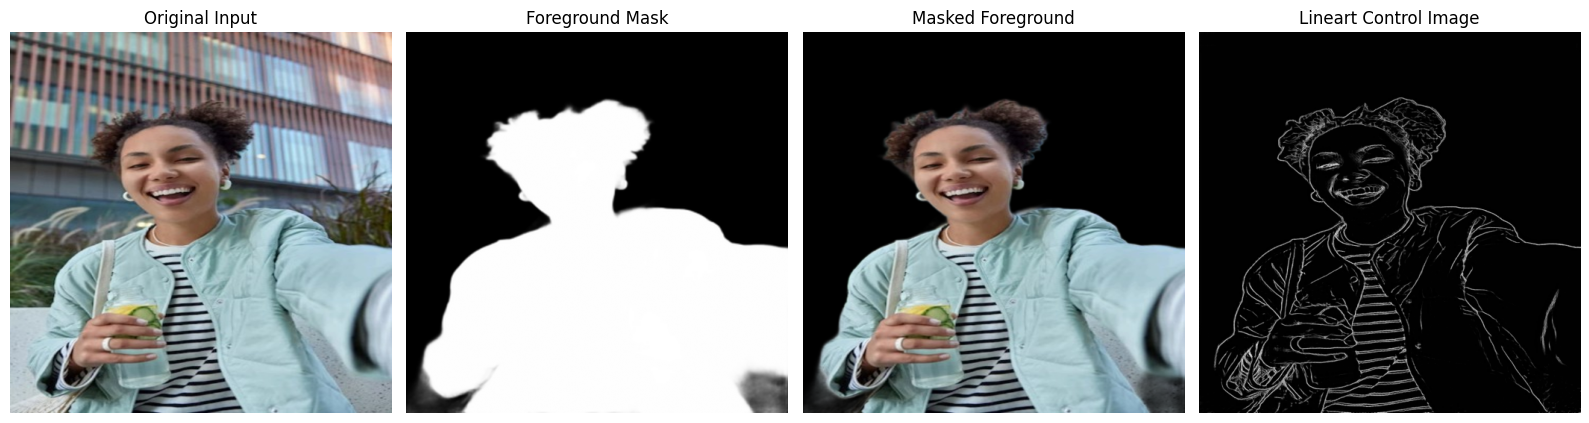

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
axes[0].imshow(image); axes[0].set_title("Original Input")
axes[1].imshow(fg_mask, cmap='gray'); axes[1].set_title("Foreground Mask")
axes[2].imshow(fg_masked); axes[2].set_title("Masked Foreground")
axes[3].imshow(control_image); axes[3].set_title("Lineart Control Image")
for ax in axes: ax.axis("off")
plt.tight_layout(); plt.show()


### Part 1 — Single Prompt on Foreground
Apply a single prompt to the masked foreground image using ControlNet. This allows controlled generation over the main subject only. Letting the background genarate freely.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

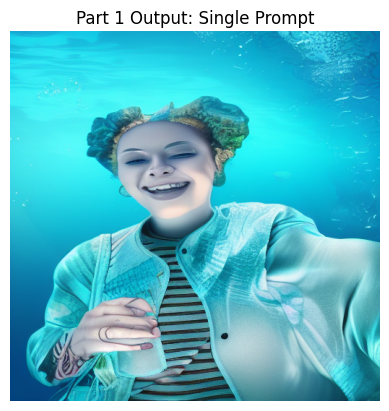

In [18]:
pipe = load_controlnet_pipeline(config.CONTROLNET_CHECKPOINT, config.SD_MODEL)

single_prompt = "mermaid underwater, blue clothes, corals and fishes background"
output_single = run_inference(pipe, single_prompt, control_image)

plt.imshow(output_single)
plt.title("Part 1 Output: Single Prompt")
plt.axis("off")
plt.show()


### Part 2 — Dual Prompts: Foreground and Background
Use two separate prompts to generate the foreground and background independently, and blend them using the mask.


In [19]:
foreground_prompt = "mermaid underwater, blue clothes"
background_prompt = "a futuristic galaxy scene with large sci-fi spaceships flying among skylights"

output_fg = run_inference(pipe, foreground_prompt, control_image)
output_bg = run_inference(pipe, background_prompt, control_image)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Visualize Foreground vs Background

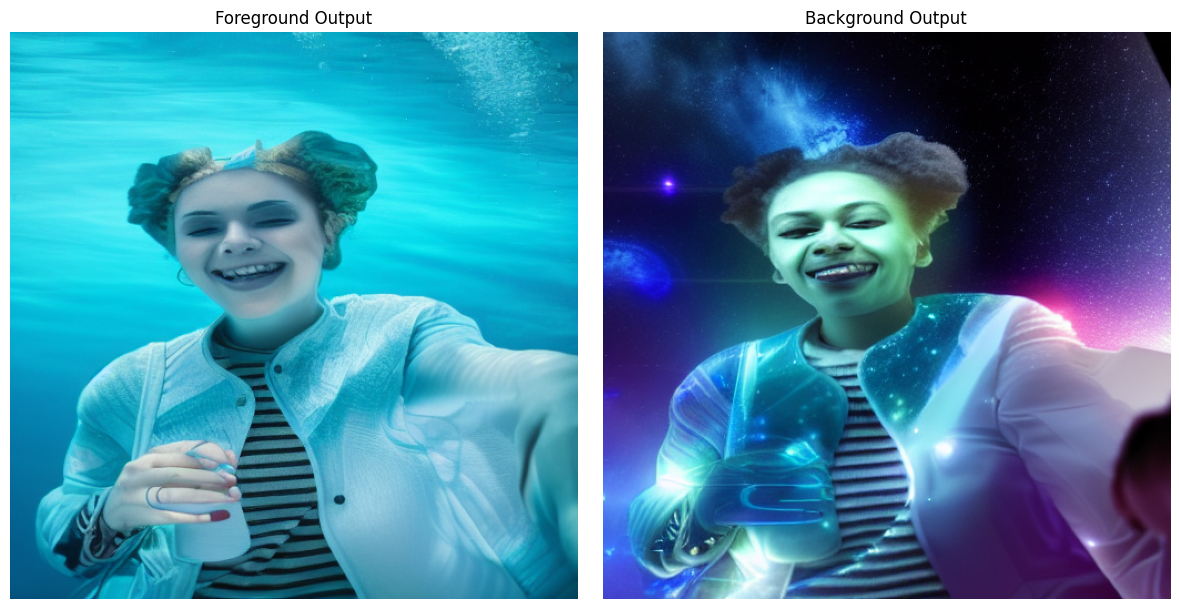

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(output_fg); axes[0].set_title("Foreground Output")
axes[1].imshow(output_bg); axes[1].set_title("Background Output")
for ax in axes: ax.axis("off")
plt.tight_layout(); plt.show()


Merge and save

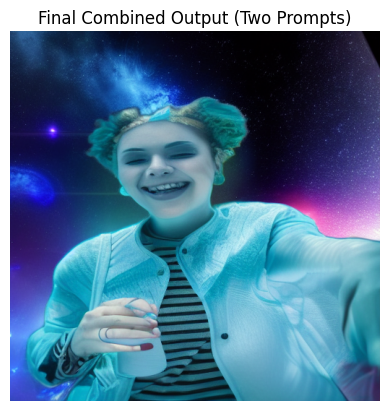

In [21]:
final = merge_images(output_fg, output_bg, fg_mask)
plt.imshow(final)
plt.title("Final Combined Output (Two Prompts)")
plt.axis("off")
plt.show()

# Save output (optional)
final.save("./final_combined.png")
